In [ ]:
# x4, 5frames, pathces, Segformer

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1,0"

In [2]:
import torch
from torch import nn
from tqdm import tqdm
import os, random, gc
import numpy as np
from src.fastai_fix import *
from src.lovasz import lovasz_sym
from src.ema import *
import tifffile
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import albumentations as A
import cv2

from src.segformer import SegFormer
from src.lovasz import lovasz_hinge

In [3]:
class CONFIG:
    path = 'data/'
    out = 'experiments/init'
    
    num_workers = 12
    seed = 2023
    bs = 12#2
    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = True

seed_everything(CONFIG.seed)
os.makedirs(CONFIG.out, exist_ok=True)

def WrapperAdamW(param_groups,**kwargs):
    return OptimWrapper(param_groups,torch.optim.AdamW)

from src.radam import Over9000
def WrapperOver9000(param_groups,**kwargs):
    #param_groups = [{'params':p} for p in param_groups]
    #return OptimWrapper(opt=Over9000(param_groups,**kwargs))
    return OptimWrapper(param_groups,opt=Over9000)

In [4]:
def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

def get_aug():
    return A.Compose([
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        #A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=30, p=0.9),
        A.OneOf([
            A.CropNonEmptyMaskIfExists(512//4,512//4,p=0.75),
            A.RandomCrop(512//4,512//4,p=0.25),
        ],p=1),
        #OneOf([
        #    OpticalDistortion(p=0.3),
        #    GridDistortion(p=0.1),
        #    PiecewiseAffine(p=0.3),
        #], p=0.4),
        #A.RandomBrightnessContrast(p=0.5)
    ], p=1)

class ContrailsDataset(Dataset):
    def __init__(self, path, train=True, tfms=None, repeat=1):
        self.path = os.path.join(path, 'train_adj2' if train else 'val_adj2')
        self.fnames = sorted([fname for fname in os.listdir(self.path) if \
                       fname.split('.')[0].split('_')[-1] == 'img'])
        self.train, self.tfms = train, tfms
        self.nc = 3
        self.repeat = repeat

    def __len__(self):
        return self.repeat*len(self.fnames)

    def __getitem__(self, idx):
        idx = idx%len(self.fnames)
        img = tifffile.imread(os.path.join(self.path, self.fnames[idx]))
        img = img.reshape(*img.shape[:2],self.nc,-1)[:,:,:,0:5]
        img = img.reshape(*img.shape[:2],-1)
        mask = tifffile.imread(os.path.join(self.path, self.fnames[idx].replace('img','mask')))

        if self.tfms is not None:
            augmented = self.tfms(image=img,mask=mask)
            img,mask = augmented['image'],augmented['mask']
        
        img = cv2.resize(img, (4*img.shape[1],4*img.shape[0]), interpolation=cv2.INTER_CUBIC)
        img,mask = img2tensor(img/255),img2tensor(mask/255)
        img = img.view(self.nc, -1, *img.shape[1:])
        
        return img,mask

In [5]:
from src.lovasz import lovasz_hinge

class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target, reduction='mean'):
        #n = input.shape[-1]
        input = input.view(-1).float()
        target = target.view(-1).float()
        loss = -target*F.logsigmoid(input)*torch.exp(self.gamma*F.logsigmoid(-input)) -\
           (1.0 - target)*F.logsigmoid(-input)*torch.exp(self.gamma*F.logsigmoid(input))
        loss = 100*loss
        return loss.mean() if reduction=='mean' else loss
    
def loss_comb(x,y):
    return FocalLoss(2)(x,y) + 0.7*lovasz_hinge(x,y,per_image=False)
    
class F_th(Metric):
    def __init__(self, ths=np.arange(0.1,0.9,0.01), beta=1): 
        self.ths = ths
        self.beta = beta
        
    def reset(self): 
        self.tp = torch.zeros(len(self.ths))
        self.fp = torch.zeros(len(self.ths))
        self.fn = torch.zeros(len(self.ths))
        
    def accumulate(self, learn):
        pred,targ = flatten_check(torch.sigmoid(learn.pred.float()), 
                                  (learn.y > 0.5).float())
        for i,th in enumerate(self.ths):
            p = (pred > th).float()
            self.tp[i] += (p*targ).float().sum().item()
            self.fp[i] += (p*(1-targ)).float().sum().item()
            self.fn[i] += ((1-p)*targ).float().sum().item()

    @property
    def value(self):
        self.dices = (1 + self.beta**2)*self.tp/\
            ((1 + self.beta**2)*self.tp + self.beta**2*self.fn + self.fp + 1e-6)
        return self.dices.max()

In [6]:
from src.segformer import * 

class LSTM_block(nn.Module):
    def __init__(self, n, **kwargs):
        super().__init__()
        self.lstm = nn.LSTM(n, n, batch_first=True, bidirectional=False, num_layers=1)
    
    def forward(self,x):
        s = x.shape
        x = x.flatten(-2,-1).permute(0,3,1,2).flatten(0,1)
        x = self.lstm(x)[0]
        x = x.view(-1,s[3],s[4],s[1],s[2]).permute(0,3,4,1,2)
        return x

class SegFormer(nn.Module):
    def __init__(self, arch='B0', pre=None, num_classes=1, ps=0.1, use_checkpoint=False, 
                 up_result=2, tta=1, **kwargs):
        super().__init__()
        if arch == 'B0':
            self.backbone = mit_b0(use_checkpoint=use_checkpoint, **kwargs)
            self.decode_head = SegFormerHead(feature_strides=[4, 8, 16, 32],
                            in_channels=[32, 64, 160, 256],embedding_dim=256)
        elif arch == 'B1':
            self.backbone = mit_b1(use_checkpoint=use_checkpoint, **kwargs)
            self.decode_head = SegFormerHead(feature_strides=[4, 8, 16, 32],
                            in_channels=[64, 128, 320, 512],embedding_dim=256)
        elif arch == 'B2':
            self.backbone = mit_b2(use_checkpoint=use_checkpoint, **kwargs)
            self.decode_head = SegFormerHead(feature_strides=[4, 8, 16, 32],
                            in_channels=[64, 128, 320, 512],embedding_dim=768)
        elif arch == 'B3':
            self.backbone = mit_b3(use_checkpoint=use_checkpoint, **kwargs)
            self.decode_head = SegFormerHead(feature_strides=[4, 8, 16, 32],
                            in_channels=[64, 128, 320, 512],embedding_dim=768)
        elif arch == 'B4':
            self.backbone = mit_b4(use_checkpoint=use_checkpoint, **kwargs)
            self.decode_head = SegFormerHead(feature_strides=[4, 8, 16, 32],
                            in_channels=[64, 128, 320, 512],embedding_dim=768)
        elif arch == 'B5':
            self.backbone = mit_b5(use_checkpoint=use_checkpoint, **kwargs)
            self.decode_head = SegFormerHead(feature_strides=[4, 8, 16, 32],
                            in_channels=[64, 128, 320, 512],embedding_dim=768)
        else:
            raise NotImplementedError
        if pre is not None:
            print(f'loading {pre}')
            self.load_state_dict(torch.load(pre)['state_dict'],strict=False)
        
        self.lstm = nn.ModuleList([LSTM_block(512),LSTM_block(320)])
        #self.final_conv = nn.Sequential(
        #    PixelShuffle_ICNR(self.decode_head.embedding_dim,self.decode_head.embedding_dim//4),
        #    nn.Dropout2d(ps), nn.Conv2d(self.decode_head.embedding_dim//4,num_classes, 3, padding=1))
        self.final_conv = nn.Conv2d(self.decode_head.embedding_dim,num_classes, 3, padding=1)
        self.up_result,self.tta = up_result,tta
        
    def pred(self, x):
        nt = x.shape[2]
        x = x.permute(0,2,1,3,4).flatten(0,1)
        x = self.backbone(x)
        
        x = [x[0].view(-1,nt,*x[0].shape[1:])[:,-1], x[1].view(-1,nt,*x[1].shape[1:])[:,-1], 
             self.lstm[1](x[2].view(-1,nt,*x[2].shape[1:]))[:,-1],
             self.lstm[0](x[3].view(-1,nt,*x[3].shape[1:]))[:,-1]]
        x = self.decode_head(x)
        
        if self.up_result != 0: x = F.interpolate(self.final_conv(x),
                            scale_factor=self.up_result,mode='bilinear',align_corners=False)
        return x
    
    def forward(self,x):
        if self.training: return self.pred(x)
        else: return torch.stack([TTAi(self.pred(TTA(x,i)),i) 
                                  for i in range(self.tta)], 0).mean(0)

In [7]:
OUT = 'experiments'
fname = 'init20'

for fold in range(1):
    ds_train = ContrailsDataset(CONFIG.path, train=True, tfms=get_aug(), repeat=4)
    ds_val = ContrailsDataset(CONFIG.path, train=False, tfms=None)
    dl_train = DataLoader(ds_train, CONFIG.bs, num_workers=CONFIG.num_workers, shuffle=True, drop_last=True)
    dl_val = DataLoader(ds_val, 4, num_workers=CONFIG.num_workers, shuffle=False, drop_last=False)
    
    model = SegFormer(arch='B2', pre='segformer.b2.512x512.ade.160k.pth', num_classes=1, 
                      ps=0,up_result=1,tta=4).cuda()
    model = nn.DataParallel(model)
    
    data = DataLoaders(dl_train,dl_val).cuda()

    learn = Learner(data, 
                    model,
                    path = CONFIG.out, 
                    loss_func=loss_comb,
                    metrics=[F_th()],
                    cbs=[
                    GradientClip(3.0),
                    GradientAccumulation(32//CONFIG.bs),
                    CSVLogger(),
                    #SaveModelCallback(monitor='f_th'),
                    ],
                    opt_func=partial(WrapperOver9000,eps=1e-4),
                    #splitter = SwinFormer.split_layers
                   ).to_fp16()
    
    learn.fit_one_cycle(36, lr_max=3.5e-4, pct_start=0.1)
    torch.save(learn.model.module.state_dict(),os.path.join(OUT,f'{fname}_{fold}.pth'))
    
    #del learn, data, ds_train, ds_val
    gc.collect()
    torch.cuda.empty_cache()

loading segformer.b2.512x512.ade.160k.pth


epoch,train_loss,valid_loss,f_th,time
0,2.223584,1.564781,0.573713,48:48
1,2.142831,1.489146,0.611887,49:17
2,2.063188,1.448215,0.625069,49:27
3,2.066903,1.392686,0.642068,49:19
4,1.976503,1.395204,0.654774,49:23
5,2.006017,1.460788,0.622946,49:36
6,2.039080,1.504097,0.650922,49:39
7,1.907243,1.368149,0.663795,49:38
8,1.942356,1.368298,0.669676,49:37
9,1.974628,1.347996,0.673089,50:03


/host/Users/iafos/Documents/Jupyter/Contrails/src/radam.py:576: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Better model found at epoch 0 with f_th value: 0.5737127065658569.
Better model found at epoch 1 with f_th value: 0.6118872761726379.
Better model found at epoch 2 with f_th value: 0.6250688433647156.
Better model found at epoch 3 with f_th value: 0.6420682668685913.
Better model found at epoch 4 with f_th value: 0.6547737121582031.
Better model found at epoch 7 with f_th value: 0.6637951135635376.
Better model found at epoch 8 with f_th value: 0.6696761846542358.
Better model found at epoch 9 with f_th value: 0.6730886697769165.
Better model found at epoch 10 with f_th value: 0.678978443145752.
Better model found at epoch 13 with f_th value: 0.6830256581306458.
Better model found at epoch 17 with f_th value: 0.6862501502037048.


KeyboardInterrupt: 

In [8]:
torch.save(learn.model.module.state_dict(),os.path.join(OUT,f'{fname}_{fold}.pth'))

In [7]:
OUT = 'experiments'
fname = 'init20'

for fold in range(1):
    ds_train = ContrailsDataset(CONFIG.path, train=True)
    ds_val = ContrailsDataset(CONFIG.path, train=False, tfms=None)
    
    data = ImageDataLoaders.from_dsets(ds_train,
                                   ds_val,
                                   bs=CONFIG.bs,
                                   num_workers=CONFIG.num_workers,
                                   pin_memory=True
                                  ).cuda()

    model = SegFormer(arch='B2', pre='segformer.b2.512x512.ade.160k.pth', num_classes=1, 
                      ps=0,up_result=1, tta=8).cuda()
    model.load_state_dict(torch.load(os.path.join(OUT,f'{fname}_{fold}.pth')))
    model = nn.DataParallel(model)
    learn = Learner(data, 
                    model,
                    path = CONFIG.out, 
                    loss_func=lovasz_sym,
                    metrics=[F_th()],
                    cbs=[
                    GradientClip(3.0),
                    GradientAccumulation(32//CONFIG.bs),
                    CSVLogger(),
                    #SaveModelCallback(monitor='f_th'),
                    #EMAWarmupCallback(final_decay=0.998)
                    ],
                    opt_func=partial(WrapperOver9000,eps=1e-4),
                   ).to_fp16()
    
    #learn.fit_one_cycle(24, lr_max=4e-4, pct_start=0.05)
    #torch.save(learn.model.module.state_dict(),os.path.join(OUT,f'{fname}_{fold}.pth'))
    
    #del learn, data, ds_train, ds_val
    #gc.collect()
    #torch.cuda.empty_cache()
    learn.validate()

loading segformer.b2.512x512.ade.160k.pth


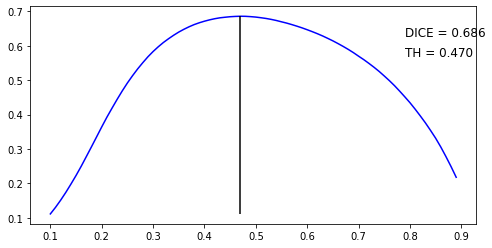

In [8]:
metric = learn.metrics[0]
dices = (1 + metric.beta**2)*metric.tp/\
        ((1 + metric.beta**2)*metric.tp + metric.beta**2*metric.fn + metric.fp + 1e-6)
ths = metric.ths

best_dice = dices.max()
best_thr = ths[dices.argmax()]
plt.figure(figsize=(8,4))
plt.plot(ths, dices, color='blue')
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max(), colors='black')
d = dices.max() - dices.min()
plt.text(ths[-1]-0.1, best_dice-0.1*d, f'DICE = {best_dice:.3f}', fontsize=12);
plt.text(ths[-1]-0.1, best_dice-0.2*d, f'TH = {best_thr:.3f}', fontsize=12);
plt.show()